# LSN - simulation test code

In [1]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import random
import time
import math
import pandas as pd
from datetime import datetime

# LSN Class and other functions

In [2]:
# Main slim library
slim = tf.contrib.slim

class siamese_net(object):
  
    def __init__(self, net_arch):
              
        self.input_L = tf.placeholder(tf.float32, [None, net_arch['MR_shape']],name='baseline')
        self.input_R = tf.placeholder(tf.float32, [None, net_arch['MR_shape']],name='follow_up')
        self.aux_gen = tf.placeholder(tf.float32, [None,1],name='apoe')  #apoe4 status
        self.aux_clinical = tf.placeholder(tf.float32, [None,net_arch['aux_shape']-1],name='clinical_attr')
        self.labels = tf.placeholder(tf.float32, [None,net_arch['output']],name='trajectory')                
        self.is_training = True  #toggles dropout in slim
        self.dropout = 1      

        with tf.variable_scope("siamese") as scope:
            self.branch_L = self.mlpnet_slim(self.input_L, net_arch)
            scope.reuse_variables()
            self.branch_R = self.mlpnet_slim(self.input_R, net_arch)

        # Create metrics      
        self.distance = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(self.branch_L,self.branch_R),2),1))
        self.preds = self.get_predictions(net_arch)
        self.loss = self.get_loss()
        self.accuracy = self.get_accuracy()

    # Individual branch    
    def mlpnet_slim(self, X, net_arch):
        with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu,
                            weights_regularizer=slim.l2_regularizer(net_arch['reg'])):

            # If needed, within the scope layer is made linear by setting activation_fn=None.
            # Creates a fully connected layers 
            for l in range(net_arch['n_layers']):
                net = slim.fully_connected(X, net_arch['l{}'.format(l+1)],normalizer_fn=slim.batch_norm,scope='fc{}'.format(l))
                net = slim.dropout(net, self.dropout, is_training=self.is_training)

            # MR output
            MR_predictions = slim.fully_connected(net, net_arch['MR_output'], 
                                                  normalizer_fn=slim.batch_norm, scope='MR_prediction')               

            return MR_predictions #Later also return end_points 
    
    # Auxilary branch for demographics, genetics, and clinical attributes
    def auxnet(self,net_arch):
        distance_vec  = tf.concat([self.branch_L,self.branch_R],1,name='MR_embed_concat')
        distance_vec_mod = tf.multiply(distance_vec,self.aux_gen)
        distance_vec_mod_aux = tf.concat([distance_vec_mod,self.aux_clinical],1)

        with tf.name_scope('aux_layers'):
            aux_predictions = slim.fully_connected(distance_vec_mod_aux, net_arch['aux_output'],
                                                   activation_fn=tf.nn.relu, 
                                                   weights_regularizer=slim.l2_regularizer(net_arch['reg']),
                                                   normalizer_fn=slim.batch_norm) 
            aux_predictions = slim.dropout(aux_predictions, self.dropout, is_training=self.is_training)
            return aux_predictions

    def get_predictions(self, net_arch):
        if net_arch['use_aux']:
            embed_vec = self.auxnet(net_arch)        
            print('Using MR and aux features')
        else:
            embed_vec = tf.concat([self.branch_L,self.branch_R],1,name='MR_embed_concat')            
            print('Using only MR features')

        penult_predict = slim.fully_connected(embed_vec, net_arch['output'], activation_fn=tf.nn.softmax, 
                                               normalizer_fn=slim.batch_norm, scope='aux_prediction')
        return penult_predict

    #-------------- net with basic/raw TF code (without slim) --------------#
    #-------------- not used when slim is used (preferred)------------------#
    def mlpnet(self, X):
        l1 = self.mlp(X,layer_config['MR_shape'],layer_config['l1'],name='l1')
        l1 = tf.nn.dropout(l1,self.dropout)
        l2 = self.mlp(l1,layer_config['l1'],layer_config['l2'],name='l2')
        l2 = tf.nn.dropout(l2,self.dropout_f)
        l3 = self.mlp(l2,layer_config['l2'],layer_config['l3'],name='l3')
        l3 = tf.nn.dropout(l3,self.dropout)
        l4 = self.mlp(l3,layer_config['l3'],layer_config['l4'],name='l4')
        l4 = tf.nn.dropout(l4,self.dropout)
        output = self.mlp(l4,layer_config['l4'],layer_config['output'],name='output')
        return output
      
    def mlp(self, input_,input_dim,output_dim,name="mlp"):
        with tf.variable_scope(name):
            w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.001,stddev=0.02))            
            b = tf.get_variable('b',[output_dim],tf.float32,tf.constant_initializer(0.1))
            return tf.nn.relu(tf.matmul(input_,w)+b)   
    #-----------------------------------------------------------------------#
   
    # Set methods for class variables
    def set_dropout(self, dropout):
        self.dropout = dropout
      
    def set_train_mode(self,is_training):  
        self.is_training = is_training
      
    # Get methods for loss and acc metrics
    def get_loss(self):            
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels,logits=self.preds)) 

    def get_accuracy(self):
        correct_preds = tf.equal(tf.argmax(self.labels,1), tf.argmax(self.preds,1))
        return tf.reduce_mean(tf.cast(correct_preds, tf.float32)) 

    
# Other helper functions
def next_batch(s,e,mr_inputs,aux_inputs,labels):
    input1 = mr_inputs[s:e,0]
    input2 = mr_inputs[s:e,1]        
    input3 = aux_inputs[s:e,:]
    y = labels[s:e,:]    
    return input1,input2,input3,y
  
def check_data_shapes(data,net_arch):
    check = True  
    n_layers = net_arch['n_layers']
    if data['X_MR'].shape[1] != 2:
        print('wrong input data dimensions - need MR data for two branches')
        check = False
    elif data['X_MR'].shape[2] != net_arch['MR_shape']:
        print('input MR data <-> LSN arch mismatch')
        check = False
    elif data['X_aux'].shape[1] != net_arch['aux_shape']:
        print('input aux data <-> LSN arch mismatch')
        check = False
    elif data['y'].shape[1] != net_arch['output']:
        print('number of classes (2,3) <-> LSN arch mismatch')
        check = False
    else:
        for l in range(n_layers):
            try:
                _ = net_arch['l{}'.format(l+1)]
            except:
                print('Specify number of nodes for layer {}'.format(l))
                check = False        

    return check

In [3]:
# Train and test defs
def train_lsn(sess, lsn, data, optimizer, n_epochs, batch_size, dropout, validate_after, verbose):
    valid_frac = int(0.1*len(data['y']))
    
    # Split into train and valid data for hyperparam tuning
    X_MR_train = data['X_MR'][:1-valid_frac]
    X_aux_train = data['X_aux'][:1-valid_frac]
    y_train = data['y'][:1-valid_frac]

    X_MR_valid = data['X_MR'][1-valid_frac:]
    X_aux_valid = data['X_aux'][1-valid_frac:]
    y_valid = data['y'][1-valid_frac:]

    total_batch = int(len(y_train)/batch_size)
    #print('total_batch {}'.format(total_batch))
    
    train_acc_list = []
    valid_acc_list = []
    train_loss_list = []
    valid_loss_list = []
    
    # Training cycle
    for epoch in range(n_epochs):
        avg_loss = 0.
        avg_acc = 0.
        start_time = time.time()
        # Loop over all batches
        for i in range(total_batch):
            s  = i * batch_size
            e = (i+1) *batch_size

            # Fit training using batch data
            MR_L_batch,MR_R_batch,aux_batch,y_batch = next_batch(s,e,X_MR_train,X_aux_train,y_train)

            # Train pass
            lsn.set_dropout(dropout)
            _,distance,preds,loss_value,acc_value=sess.run([optimizer,lsn.distance,lsn.preds,lsn.loss,lsn.accuracy], 
                                        feed_dict={lsn.input_L:MR_L_batch,
                                                   lsn.input_R:MR_R_batch,
                                                   lsn.aux_gen:aux_batch[:,0:1],
                                                   lsn.aux_clinical:aux_batch[:,1:],
                                                   lsn.labels:y_batch})                

            avg_loss += loss_value
            avg_acc +=acc_value*100

        duration = time.time() - start_time
        if verbose:
            print('epoch %d  time: %.2f loss %0.4f acc %0.2f' %(epoch,duration,avg_loss/total_batch,avg_acc/total_batch))      

        #Compute perf on entire training and validation sets (no need after every epoch)
        if epoch%validate_after == 0:
            train_acc = lsn.accuracy.eval(feed_dict={lsn.input_L:X_MR_train[:,0,:],lsn.input_R:X_MR_train[:,1,:],
                                         lsn.aux_gen:X_aux_train[:,0:1],lsn.aux_clinical:X_aux_train[:,1:],
                                         lsn.labels:y_train})
            valid_acc = lsn.accuracy.eval(feed_dict={lsn.input_L:X_MR_valid[:,0,:],lsn.input_R:X_MR_valid[:,1,:],
                                         lsn.aux_gen:X_aux_valid[:,0:1],lsn.aux_clinical:X_aux_valid[:,1:],
                                         lsn.labels:y_valid})
            train_loss = lsn.loss.eval(feed_dict={lsn.input_L:X_MR_train[:,0,:],lsn.input_R:X_MR_train[:,1,:],
                                         lsn.aux_gen:X_aux_train[:,0:1],lsn.aux_clinical:X_aux_train[:,1:],
                                         lsn.labels:y_train})
            valid_loss = lsn.loss.eval(feed_dict={lsn.input_L:X_MR_valid[:,0,:],lsn.input_R:X_MR_valid[:,1,:],
                                         lsn.aux_gen:X_aux_valid[:,0:1],lsn.aux_clinical:X_aux_valid[:,1:],
                                         lsn.labels:y_valid})
            print('performance on entire train and valid subsets')
            print('epoch {}\t train_acc:{}\t valid_acc:{}\n'.format(epoch,train_acc,valid_acc))
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
  
    # -----------TODO--------------
    # Save trained model
    # -----------TODO--------------

    # Post training: Compute preds and metrics for entire train data
    X_MR_train = data['X_MR']
    X_aux_train = data['X_aux']
    y_train = data['y']
    train_feature_L = lsn.branch_L.eval(feed_dict={lsn.input_L:X_MR_train[:,0,:]})
    train_feature_R = lsn.branch_R.eval(feed_dict={lsn.input_R:X_MR_train[:,1,:]})    
    train_preds= lsn.preds.eval(feed_dict={lsn.input_L:X_MR_train[:,0,:],lsn.input_R:X_MR_train[:,1,:],
                                  lsn.aux_gen:X_aux_train[:,0:1],lsn.aux_clinical:X_aux_train[:,1:]})

    train_metrics = {'train_feature_L':train_feature_L,'train_feature_R':train_feature_R,'train_preds':train_preds,
                     'train_loss':train_loss_list,'train_acc':train_acc_list,
                     'valid_loss':valid_loss_list,'valid_acc':valid_acc_list}

    return lsn, train_metrics

def test_lsn(sess,lsn,data):
    print('Testing model')    
    lsn.set_dropout(1)
    lsn.set_train_mode(False) 
    X_MR_test = data['X_MR']
    X_aux_test = data['X_aux']
    y_test = data['y']
    #print(lsn.dropout)

    test_feature_L = lsn.branch_L.eval(feed_dict={lsn.input_L:X_MR_test[:,0,:]})
    test_feature_R = lsn.branch_R.eval(feed_dict={lsn.input_R:X_MR_test[:,1,:]})

    test_preds = lsn.preds.eval(feed_dict={lsn.input_L:X_MR_test[:,0,:],lsn.input_R:X_MR_test[:,1,:],
                                      lsn.aux_gen:X_aux_test[:,0:1],lsn.aux_clinical:X_aux_test[:,1:]})
    test_acc = lsn.accuracy.eval(feed_dict={lsn.input_L:X_MR_test[:,0,:],lsn.input_R:X_MR_test[:,1,:],
                                       lsn.aux_gen:X_aux_test[:,0:1],lsn.aux_clinical:X_aux_test[:,1:],
                                       lsn.labels:y_test})

    test_metrics = {'test_feature_L':test_feature_L,'test_feature_R':test_feature_R,'test_preds':test_preds,'test_acc':test_acc}
    print('Accuracy test set %0.2f' % (100 * test_acc))
    return lsn, test_metrics


# Generate simulation data 

In [4]:

sampx = 10000
X_MR = np.squeeze(np.random.rand(2*sampx,2,100))
X_aux = np.squeeze(np.random.rand(2*sampx,5))

# Modify feature distributions of the first half of the sample 
X_MR[:sampx] = X_MR[:sampx]/1.5
X_aux[:sampx] = X_aux[:sampx]/2.0
y = np.concatenate((np.ones(sampx),np.zeros(sampx)))
y = np.squeeze(np.vstack((1-y,y)).T)
 
# Shuffle data before train-test split
indx_shuff = np.arange(2*sampx)
np.random.shuffle(indx_shuff)
X_MR = np.squeeze(X_MR[indx_shuff])
X_aux = np.squeeze(X_aux[indx_shuff])
y = np.squeeze(y[indx_shuff])

# Train-test splits
train_frac = int(0.9*(2*sampx))
X_MR_train = X_MR[:train_frac]
X_aux_train = X_aux[:train_frac]
y_train = y[:train_frac]

X_MR_test = X_MR[train_frac:]
X_aux_test = X_aux[train_frac:]
y_test = y[train_frac:]
subject_idx_test = indx_shuff[train_frac:]

print('shapes of X_MR_train:{}, X_aux_train:{}, y_train:{}, \n\t X_MR_test:{}, X_aux_test:{}, y_test:{}'.format(X_MR_train.shape,X_aux_train.shape,y_train.shape,X_MR_test.shape,X_aux_train.shape,y_test.shape)) 

shapes of X_MR_train:(18000, 2, 100), X_aux_train:(18000, 5), y_train:(18000, 2), 
	 X_MR_test:(2000, 2, 100), X_aux_test:(18000, 5), y_test:(2000, 2)


In [5]:
# Check differences in feature distributions
print('train distributions')
class_0 = np.mean(X_aux_train[y_train[:,0]==0],axis=0)
class_1 = np.mean(X_aux_train[y_train[:,0]==1],axis=0)
print(class_0,class_1)
print('test distributions')
class_0 = np.mean(X_aux_test[y_test[:,0]==0],axis=0)
class_1 = np.mean(X_aux_test[y_test[:,0]==1],axis=0)
print(class_0,class_1)

train distributions
[0.24960257 0.24992984 0.24920156 0.25287756 0.248295  ] [0.50018313 0.50571437 0.50166863 0.50176378 0.50164929]
test distributions
[0.24483155 0.24622588 0.24522371 0.24720636 0.25268973] [0.50081535 0.4947881  0.50079135 0.49282946 0.49848341]


# Train and test a sample LSN

In [6]:
# training params
lr = 0.001
n_epochs = 10
validate_after = 2
batch_size = 100
dropout = 0.8 #keep_prob
verbose = False # Do you want to print perf after every epoch?? 

net_arch = {'MR_shape':100,'n_layers':4,'l1':50,'l2':50,'l3':25,'l4':25,'l5':25,'MR_output':10,
            'use_aux':True,'aux_shape':5,'aux_output':2,'output':2,'reg':0.1}

# minimal perf df --> append CV related attributes downstream. 
perf_df = pd.DataFrame(columns=['subject_id','label','pred_prob','pred_label'])

tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:        
    # Train model    
    data = {'X_MR':X_MR_train,'X_aux':X_aux_train,'y':y_train}    
    if check_data_shapes(data,net_arch):      
        print('train data <-> net_arch check passed')   
        lsn = siamese_net(net_arch)        
        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(lsn.loss)
        tf.global_variables_initializer().run()

        cur_time = datetime.time(datetime.now())
        print('\nStart training time: {}'.format(cur_time))                
        lsn, train_metrics = train_lsn(sess, lsn, data, optimizer, n_epochs, batch_size, dropout,validate_after,verbose)
        cur_time = datetime.time(datetime.now())
        print('End training time: {}\n'.format(cur_time))  
      
    else:
        print('train data <-> net_arch check failed')

    # Test model      
    data = {'X_MR':X_MR_test,'X_aux':X_aux_test,'y':y_test}
    if check_data_shapes(data,net_arch):
        print('test data <-> net_arch check passed')   
        _,test_metrics = test_lsn(sess,lsn,data)        
        # populate perf dataframe
        perf_df['subject_id']  = subject_idx_test
        perf_df['label'] = np.argmax(y_test,1)
        perf_df['pred_prob'] = list(test_metrics['test_preds'])
        perf_df['pred_label'] = np.argmax(test_metrics['test_preds'],1)
    else:
        print('test data <-> net_arch check failed')   


train data <-> net_arch check passed
Using MR and aux features

Start training time: 14:42:08.303640
performance on entire train and valid subsets
epoch 0	 train_acc:0.9205604791641235	 valid_acc:0.9288493394851685

performance on entire train and valid subsets
epoch 2	 train_acc:0.9637059569358826	 valid_acc:0.9599777460098267

performance on entire train and valid subsets
epoch 4	 train_acc:0.9822233319282532	 valid_acc:0.976097822189331

performance on entire train and valid subsets
epoch 6	 train_acc:0.9870378375053406	 valid_acc:0.979433000087738

performance on entire train and valid subsets
epoch 8	 train_acc:0.988334059715271	 valid_acc:0.9822123646736145

End training time: 14:42:12.133096

test data <-> net_arch check passed
Testing model
Accuracy test set 98.45


# Plots

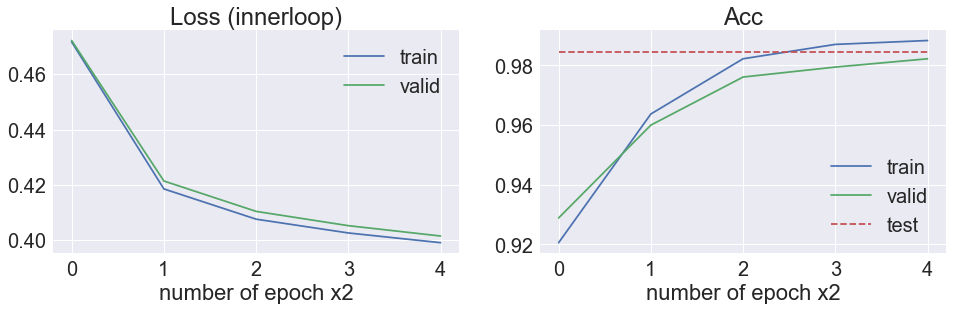

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

plt.figure(figsize=(16,9))
plt.style.use('seaborn-white')
sns.set(font_scale=2)
train_loss = train_metrics['train_loss']
valid_loss = train_metrics['valid_loss']
train_acc = train_metrics['train_acc']
valid_acc = train_metrics['valid_acc']

plt.subplot(2,2,1)
plt.plot(train_loss,label='train');
plt.plot(valid_loss,label='valid');
plt.title('Loss (innerloop)')
plt.xlabel('number of epoch x{}'.format(validate_after))
plt.legend()

plt.subplot(2,2,2)
plt.plot(train_acc,label='train');
plt.plot(valid_acc,label='valid');
plt.plot(np.tile(test_metrics['test_acc'],len(train_acc)),'--',label='test')
plt.title('Acc')
plt.xlabel('number of epoch x{}'.format(validate_after))
plt.legend()

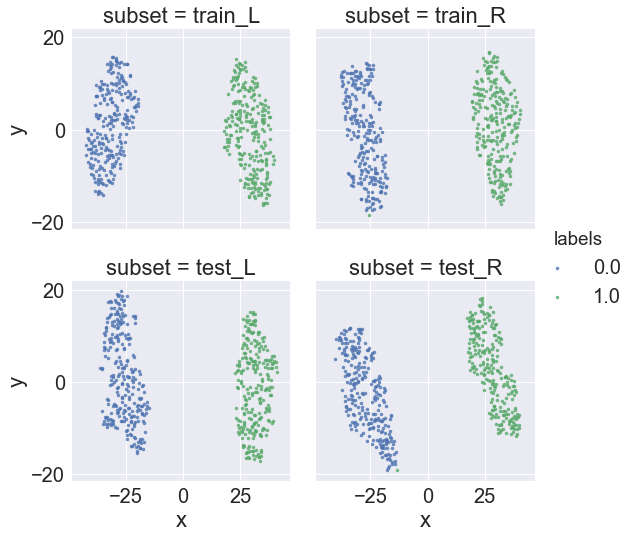

In [8]:
#Plot TSNE
tsne_sampx = 500 #Too slow for large number of samples
train_embed_L = train_metrics['train_feature_L']
train_embed_R = train_metrics['train_feature_R']

test_embed_L = test_metrics['test_feature_L']
test_embed_R = test_metrics['test_feature_R']

train_tsne_embed_L = TSNE(n_components=2,init='pca').fit_transform(train_embed_L[:tsne_sampx])
test_tsne_embed_L = TSNE(n_components=2,init='pca').fit_transform(test_embed_L[:tsne_sampx])
train_tsne_embed_R = TSNE(n_components=2,init='pca').fit_transform(train_embed_R[:tsne_sampx])
test_tsne_embed_R = TSNE(n_components=2,init='pca').fit_transform(test_embed_R[:tsne_sampx])


train_df_L = pd.DataFrame(columns=['x','y','labels','subset'])
test_df_L = pd.DataFrame(columns=['x','y','labels','subset'])
train_df_R = pd.DataFrame(columns=['x','y','labels','subset'])
test_df_R = pd.DataFrame(columns=['x','y','labels','subset'])

train_df_L['x'] = train_tsne_embed_L[:,0] 
train_df_L['y'] = train_tsne_embed_L[:,1] 
train_df_L['labels'] = y_train[:tsne_sampx]
train_df_L['subset'] = np.tile('train_L',len(y_train[:tsne_sampx]))

train_df_R['x'] = train_tsne_embed_R[:,0] 
train_df_R['y'] = train_tsne_embed_R[:,1] 
train_df_R['labels'] = y_train[:tsne_sampx]
train_df_R['subset'] = np.tile('train_R',len(y_train[:tsne_sampx]))

test_df_L['x'] = test_tsne_embed_L[:,0] 
test_df_L['y'] = test_tsne_embed_L[:,1] 
test_df_L['labels'] = y_test[:tsne_sampx]
test_df_L['subset'] = np.tile('test_L',len(y_test[:tsne_sampx]))

test_df_R['x'] = test_tsne_embed_R[:,0] 
test_df_R['y'] = test_tsne_embed_R[:,1] 
test_df_R['labels'] = y_test[:tsne_sampx]
test_df_R['subset'] = np.tile('test_R',len(y_test[:tsne_sampx]))


plot_df = train_df_L.append(train_df_R).append(test_df_L).append(test_df_R)
sns.lmplot(x='x',y='y',hue='labels',col='subset',col_wrap=2, fit_reg=False, markers='.',data=plot_df,size=4);

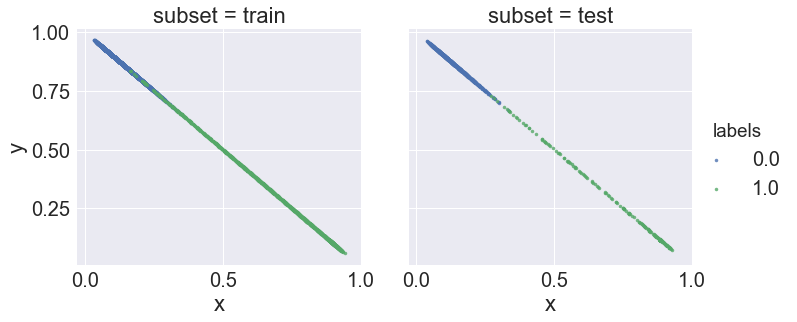

In [9]:
# Plot preds
train_features = train_metrics['train_preds']
test_features = test_metrics['test_preds']

train_df = pd.DataFrame(columns=['x','y','labels','subset'])
test_df = pd.DataFrame(columns=['x','y','labels','subset'])
train_df['x'] = train_features[:,0] 
train_df['y'] = train_features[:,1] 
train_df['labels'] = y_train
train_df['subset'] = np.tile('train',len(y_train))
test_df['x'] = test_features[:,0] 
test_df['y'] = test_features[:,1] 
test_df['labels'] = y_test
test_df['subset'] = np.tile('test',len(y_test))
plot_df = train_df.append(test_df)
sns.lmplot(x='x',y='y',hue='labels',col='subset',fit_reg=False, markers='.',data=plot_df);
